In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
#hide
from fastbook import *

# Other Computer Vision Problems

## Multi-Label Classification

### The Data

In [4]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


### Sidebar: Pandas and DataFrames

In [6]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [7]:
df.iloc[0,:]
# Trailing :s are always optional (in numpy, pytorch, pandas, etc.),
#   so this is equivalent:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [8]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [9]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


In [10]:
tmp_df['c'] = tmp_df['a']+tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


### End sidebar

### Constructing a DataBlock

In [11]:
dblock = DataBlock()

In [12]:
dsets = dblock.datasets(df)

In [13]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [14]:
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object, fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [15]:
x['fname']

'008663.jpg'

In [16]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [17]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

In [18]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/002844.jpg'), ['train'])

In [19]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [20]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['dog']

In [21]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [22]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

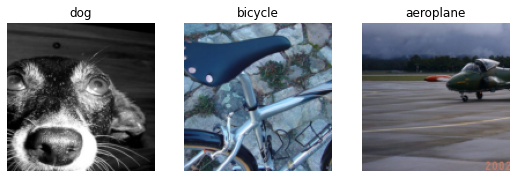

In [23]:
dls.show_batch(nrows=1, ncols=3)

### Binary Cross-Entropy

In [24]:
learn = cnn_learner(dls, resnet18)

TensorMultiCategory([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [34]:
# x,y = dls.train.one_batch()
x,y = to_cpu(dls.train.one_batch())
print (x.shape,y.shape)
activs = learn.model(x)
activs.shape

torch.Size([64, 3, 128, 128]) torch.Size([64, 20])


torch.Size([64, 20])

In [35]:
activs[0]

TensorImage([-1.1906, -1.6316, -0.7287, -1.0715,  4.2458,  3.2745, -2.2501, -1.1408,  4.7907, -0.4804,  0.7336, -0.7747,  1.2169, -4.2086, -4.3390, -4.9249,  2.7559, -2.6321,  3.1252, -5.6200],
       grad_fn=<AliasBackward>)

In [36]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [37]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorImage(1.0674, grad_fn=<AliasBackward>)

In [38]:
def say_hello(name, say_what="Hello"): return f"{say_what} {name}."
say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

In [39]:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

In [40]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.934918,0.700175,0.232689,00:40
1,0.817401,0.552276,0.291574,00:39
2,0.597446,0.200146,0.823944,00:39
3,0.357290,0.125047,0.941813,00:39


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.131649,0.116450,0.945877,00:44
1,0.116903,0.105238,0.949084,00:44
2,0.097302,0.101156,0.953327,00:44


In [41]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.1011558473110199,0.9306573271751404]

In [42]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.1011558473110199,0.9444421529769897]

In [43]:
preds,targs = learn.get_preds()

In [44]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorImage(0.9568)

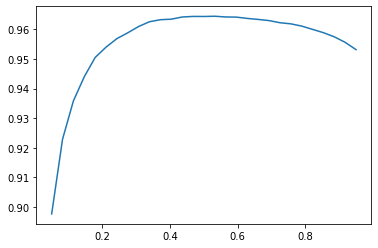

In [45]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

## Regression

### Assemble the Data

In [46]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [47]:
#hide
Path.BASE_PATH = path

In [48]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [49]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [50]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('22/frame_00246_pose.txt')

In [51]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

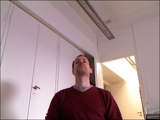

In [52]:
im.to_thumb(160)

In [53]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [54]:
get_ctr(img_files[0])

tensor([344.1721, 250.3795])

In [55]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

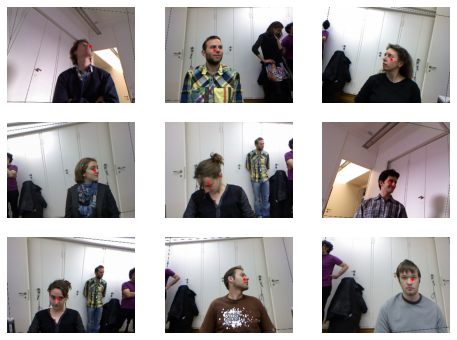

In [56]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [57]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [58]:
yb[0]

TensorPoint([[0.1056, 0.2779]], device='cuda:0')

### Training a Model

In [59]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

In [60]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

/usr/local/lib/python3.6/dist-packages/fastbook/__init__.py:55: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


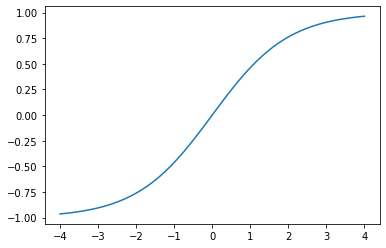

In [61]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [62]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=1.0964781722577754e-06)

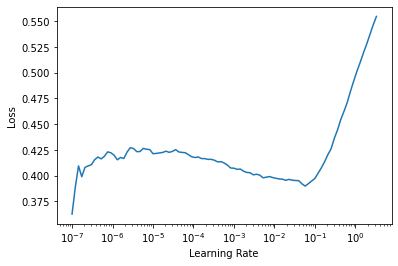

In [63]:
learn.lr_find()

In [64]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.051458,0.025456,03:24


epoch,train_loss,valid_loss,time
0,0.008340,0.003917,04:27
1,0.003125,0.000518,04:27
2,0.001497,0.000059,04:26


In [65]:
math.sqrt(0.0001)

0.01

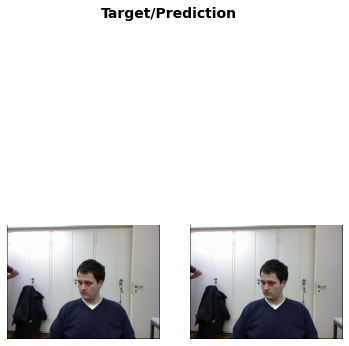

In [66]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))

## Conclusion

## Questionnaire

1. How could multi-label classification improve the usability of the bear classifier?
1. How do we encode the dependent variable in a multi-label classification problem?
1. How do you access the rows and columns of a DataFrame as if it was a matrix?
1. How do you get a column by name from a DataFrame?
1. What is the difference between a `Dataset` and `DataLoader`?
1. What does a `Datasets` object normally contain?
1. What does a `DataLoaders` object normally contain?
1. What does `lambda` do in Python?
1. What are the methods to customize how the independent and dependent variables are created with the data block API?
1. Why is softmax not an appropriate output activation function when using a one hot encoded target?
1. Why is `nll_loss` not an appropriate loss function when using a one-hot-encoded target?
1. What is the difference between `nn.BCELoss` and `nn.BCEWithLogitsLoss`?
1. Why can't we use regular accuracy in a multi-label problem?
1. When is it okay to tune a hyperparameter on the validation set?
1. How is `y_range` implemented in fastai? (See if you can implement it yourself and test it without peeking!)
1. What is a regression problem? What loss function should you use for such a problem?
1. What do you need to do to make sure the fastai library applies the same data augmentation to your inputs images and your target point coordinates?

### Further Research

1. Read a tutorial about Pandas DataFrames and experiment with a few methods that look interesting to you. See the book's website for recommended tutorials.
1. Retrain the bear classifier using multi-label classification. See if you can make it work effectively with images that don't contain any bears, including showing that information in the web application. Try an image with two different kinds of bears. Check whether the accuracy on the single-label dataset is impacted using multi-label classification.